# RRL (Regularized Rule Learner) on Boston Housing

This notebook applies RRL for regression on the Boston Housing dataset. Since RRL is originally designed for classification, we adapt it for regression by:
1. Using MSE loss instead of CrossEntropyLoss
2. Single output dimension instead of one-hot encoded classes
3. Using regression metrics (MSE, RMSE, MAE, R²)

## 1. Imports

In [1]:
# Standard library
from pathlib import Path
import warnings
import sys

# Data manipulation
import pandas as pd
import numpy as np

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm.auto import tqdm

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

RANDOM_STATE = 20251204
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

/Users/zihanghuang/data-mining/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data

In [2]:
# Resolve project paths and organize outputs
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

DATA_DIR = PROJECT_ROOT / "datasets" / "boston-housing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
for path in [OUTPUT_DIR, PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")

Project root: /Users/zihanghuang/data-mining
Outputs directory: /Users/zihanghuang/data-mining/outputs


In [3]:
data_path = DATA_DIR / "HousingDataPreprocessed.csv"
df = pd.read_csv(data_path, sep=",")
features_list = list(df.columns)
features_list.remove('MEDV')
X = df[features_list].copy()
Y = df['MEDV'].copy()

print(f"Dataset shape: {df.shape}")
print(f"Features: {features_list}")
print(f"Target: MEDV (Median value of owner-occupied homes in $1000's)")
print(f"\nTarget statistics:")
print(Y.describe())

Dataset shape: (506, 12)
Features: ['ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT', 'CRT_COMBO']
Target: MEDV (Median value of owner-occupied homes in $1000's)

Target statistics:
count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64


In [4]:
# Convert CHAS to categorical
X['CHAS'] = X['CHAS'].astype('category')

# Identify column types
categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols}")

Categorical features (1): ['CHAS']
Numeric features (10): ['ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT', 'CRT_COMBO']


## 3. Train/Test Split and Preprocessing

In [5]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 404 samples
Test set: 102 samples


In [6]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

# Fit and transform
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()
print(f"Transformed feature count: {len(feature_names)}")
print(f"Feature names: {list(feature_names)}")

# Normalize target (helps with training stability)
y_scaler = StandardScaler()
Y_train_scaled = y_scaler.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
Y_test_scaled = y_scaler.transform(Y_test.values.reshape(-1, 1)).flatten()

Transformed feature count: 13
Feature names: ['cat__CHAS_0.0', 'cat__CHAS_0.3333333333333333', 'cat__CHAS_1.0', 'num__ZN', 'num__INDUS', 'num__NOX', 'num__RM', 'num__AGE', 'num__DIS', 'num__PTRATIO', 'num__B', 'num__LSTAT', 'num__CRT_COMBO']


## 4. RRL Regression Model

We adapt the RRL model for regression by modifying the loss function and output layer.

In [7]:
# Import RRL components
from rrl.components import BinarizeLayer, UnionLayer, LRLayer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
except:
    pass
print(f"Using device: {device}")

Using device: mps


In [8]:
class RegressionNet(nn.Module):
    """RRL Network adapted for regression tasks."""
    
    def __init__(self, dim_list, use_not=False, left=None, right=None, 
                 use_nlaf=False, estimated_grad=False, use_skip=True, 
                 alpha=0.999, beta=8, gamma=1, temperature=0.01):
        super(RegressionNet, self).__init__()

        self.dim_list = dim_list
        self.use_not = use_not
        self.left = left
        self.right = right
        self.layer_list = nn.ModuleList([])
        self.use_skip = use_skip
        self.t = nn.Parameter(torch.log(torch.tensor([temperature])))

        prev_layer_dim = dim_list[0]
        for i in range(1, len(dim_list)):
            num = prev_layer_dim
            
            skip_from_layer = None
            if self.use_skip and i >= 4:
                skip_from_layer = self.layer_list[-2]
                num += skip_from_layer.output_dim

            if i == 1:
                layer = BinarizeLayer(dim_list[i], num, self.use_not, self.left, self.right)
                layer_name = 'binary{}'.format(i)
            elif i == len(dim_list) - 1:
                # For regression: single output with no activation
                layer = LRLayer(dim_list[i], num)
                layer_name = 'lr{}'.format(i)
            else:
                layer_use_not = True if i != 2 else False
                layer = UnionLayer(dim_list[i], num, use_nlaf=use_nlaf, 
                                   estimated_grad=estimated_grad, use_not=layer_use_not, 
                                   alpha=alpha, beta=beta, gamma=gamma)
                layer_name = 'union{}'.format(i)
            
            layer.conn = lambda: None
            layer.conn.prev_layer = self.layer_list[-1] if len(self.layer_list) > 0 else None
            layer.conn.is_skip_to_layer = False
            layer.conn.skip_from_layer = skip_from_layer
            if skip_from_layer is not None:
                skip_from_layer.conn.is_skip_to_layer = True

            prev_layer_dim = layer.output_dim
            self.add_module(layer_name, layer)
            self.layer_list.append(layer)

    def forward(self, x):
        for layer in self.layer_list:
            if layer.conn.skip_from_layer is not None:
                x = torch.cat((x, layer.conn.skip_from_layer.x_res), dim=1)
                del layer.conn.skip_from_layer.x_res
            x = layer(x)
            if layer.conn.is_skip_to_layer:
                layer.x_res = x
        return x
    
    def bi_forward(self, x, count=False):
        for layer in self.layer_list:
            if layer.conn.skip_from_layer is not None:
                x = torch.cat((x, layer.conn.skip_from_layer.x_res), dim=1)
                del layer.conn.skip_from_layer.x_res
            x = layer.binarized_forward(x)
            if layer.conn.is_skip_to_layer:
                layer.x_res = x
            if count and layer.layer_type != 'linear':
                layer.node_activation_cnt += torch.sum(x, dim=0)
                layer.forward_tot += x.shape[0]
        return x

In [9]:
class RRLRegression:
    """RRL adapted for regression tasks."""
    
    def __init__(self, dim_list, device, use_not=False, save_best=True, 
                 save_path=None, use_skip=False, use_nlaf=False,
                 alpha=0.999, beta=8, gamma=1, temperature=0.01):
        self.dim_list = dim_list
        self.use_not = use_not
        self.use_skip = use_skip
        self.use_nlaf = use_nlaf
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.best_mse = float('inf')
        self.device = device
        self.save_best = save_best
        self.save_path = save_path
        
        self.net = RegressionNet(
            dim_list, use_not=use_not, use_nlaf=use_nlaf, 
            use_skip=use_skip, alpha=alpha, beta=beta, gamma=gamma, 
            temperature=temperature
        )
        self.net.to(self.device)

    def clip(self):
        """Clip the weights into the range [0, 1] - only for union layers."""
        for i, layer in enumerate(self.net.layer_list[:-1]):
            # Skip clipping for the first layer (BinarizeLayer) to allow more flexibility
            if i > 0:
                layer.clip()
    
    def l2_penalty(self):
        l2_penalty = 0.0
        for layer in self.net.layer_list[1:]:
            l2_penalty += layer.l2_norm()
        return l2_penalty

    def train_model(self, train_loader, valid_loader=None, epoch=50, lr=0.01, 
                    weight_decay=0.0, patience=20):
        """Train with early stopping and cosine annealing scheduler."""
        
        criterion = nn.MSELoss().to(self.device)
        optimizer = torch.optim.AdamW(self.net.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Cosine annealing with warm restarts for better convergence
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=20, T_mult=2, eta_min=lr/100
        )
        
        train_losses = []
        val_losses = []
        no_improve_count = 0
        
        epoch_pbar = tqdm(range(epoch), desc="Training", unit="epoch")
        
        for epo in epoch_pbar:
            self.net.train()
            epoch_loss = 0.0
            batch_count = 0
            
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()
                y_pred = self.net.forward(X_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=1.0)
                
                optimizer.step()
                self.clip()
                
                epoch_loss += loss.item()
                batch_count += 1
            
            scheduler.step()
            
            avg_train_loss = epoch_loss / batch_count
            train_losses.append(avg_train_loss)
            
            # Validation
            if valid_loader is not None:
                val_mse = self.evaluate(valid_loader)
                val_losses.append(val_mse)
                
                if val_mse < self.best_mse:
                    self.best_mse = val_mse
                    no_improve_count = 0
                    if self.save_best:
                        self.save_model()
                else:
                    no_improve_count += 1
                
                current_lr = optimizer.param_groups[0]['lr']
                epoch_pbar.set_postfix(
                    train_loss=f"{avg_train_loss:.4f}",
                    val_mse=f"{val_mse:.4f}",
                    best_mse=f"{self.best_mse:.4f}",
                    lr=f"{current_lr:.5f}"
                )
                
                # Early stopping
                if no_improve_count >= patience:
                    print(f"\nEarly stopping at epoch {epo+1}")
                    break
            else:
                epoch_pbar.set_postfix(train_loss=f"{avg_train_loss:.4f}")
        
        return train_losses, val_losses
    
    @torch.no_grad()
    def evaluate(self, data_loader):
        self.net.eval()
        y_true_list = []
        y_pred_list = []
        
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(self.device)
            y_pred = self.net.forward(X_batch).squeeze()
            y_true_list.append(y_batch.numpy())
            y_pred_list.append(y_pred.cpu().numpy())
        
        y_true = np.concatenate(y_true_list)
        y_pred = np.concatenate(y_pred_list)
        return mean_squared_error(y_true, y_pred)
    
    @torch.no_grad()
    def predict(self, data_loader):
        self.net.eval()
        y_pred_list = []
        
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(self.device)
            y_pred = self.net.forward(X_batch).squeeze()
            y_pred_list.append(y_pred.cpu().numpy())
        
        return np.concatenate(y_pred_list)
    
    def save_model(self):
        if self.save_path:
            rrl_args = {
                'dim_list': self.dim_list, 
                'use_not': self.use_not, 
                'use_skip': self.use_skip,
                'use_nlaf': self.use_nlaf, 
                'alpha': self.alpha, 
                'beta': self.beta, 
                'gamma': self.gamma
            }
            torch.save({
                'model_state_dict': self.net.state_dict(), 
                'rrl_args': rrl_args,
                'best_mse': self.best_mse
            }, self.save_path)
    
    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)
        self.net.load_state_dict(checkpoint['model_state_dict'])
        self.best_mse = checkpoint.get('best_mse', float('inf'))
    
    def detect_dead_node(self, data_loader):
        with torch.no_grad():
            for layer in self.net.layer_list[:-1]:
                layer.node_activation_cnt = torch.zeros(
                    layer.output_dim, dtype=torch.float32, device=self.device
                )
                layer.forward_tot = 0

            for x, y in data_loader:
                x_bar = x.to(self.device)
                self.net.bi_forward(x_bar, count=True)

    def rule_print(self, feature_name, train_loader, file=sys.stdout, mean=None, std=None):
        """Print learned rules for regression."""
        if self.net.layer_list[1].node_activation_cnt is None:
            self.detect_dead_node(train_loader)

        # For Binarize Layer
        self.net.layer_list[0].get_bound_name(feature_name, mean, std)

        # For Union Layer
        for i in range(1, len(self.net.layer_list) - 1):
            layer = self.net.layer_list[i]
            layer.get_rules(layer.conn.prev_layer, layer.conn.skip_from_layer)
            skip_rule_name = None if layer.conn.skip_from_layer is None else layer.conn.skip_from_layer.rule_name
            wrap_prev_rule = False if i == 1 else True
            layer.get_rule_description((skip_rule_name, layer.conn.prev_layer.rule_name), wrap=wrap_prev_rule)

        # For LR Layer (regression output)
        layer = self.net.layer_list[-1]
        layer.get_rule2weights(layer.conn.prev_layer, layer.conn.skip_from_layer)
        
        print('RID\tWeight\tSupport\tRule', file=file)
        print('=' * 80, file=file)
        
        # Print bias term
        if hasattr(layer, 'bl') and layer.bl is not None:
            print(f'Bias\t{layer.bl[0]:.4f}\t-\t(intercept)', file=file)
        
        for rid, w in layer.rule2weights:
            now_layer = self.net.layer_list[-1 + rid[0]]
            support = (now_layer.node_activation_cnt[layer.rid2dim[rid]] / now_layer.forward_tot).item()
            print(f'{rid}\t{w[0]:.4f}\t{support:.4f}\t{now_layer.rule_name[rid[1]]}', file=file)
        
        print('#' * 80, file=file)
        return layer.rule2weights

## 5. Create Data Loaders

In [10]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create a non-shuffled train loader for evaluation (to maintain order)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)} (batch_size={batch_size})")
print(f"Test batches: {len(test_loader)}")

Training batches: 26 (batch_size=16)
Test batches: 7


## 6. Initialize and Train RRL Model

In [11]:
# Calculate feature dimensions from preprocessor output
cat_transformer = preprocessor.named_transformers_['cat']
discrete_flen = len(cat_transformer.get_feature_names_out())
total_features = X_train_transformed.shape[1]
continuous_flen = total_features - discrete_flen

print(f"Discrete features: {discrete_flen}")
print(f"Continuous features: {continuous_flen}")
print(f"Total input features: {total_features}")

# Model path for saving
rrl_model_path = MODELS_DIR / 'rrl_housing_model.pth'

# Verify dimensions match
assert discrete_flen + continuous_flen == total_features, \
    f"Feature dimension mismatch: {discrete_flen} + {continuous_flen} != {total_features}"

Discrete features: 3
Continuous features: 10
Total input features: 13


In [12]:
# Hyperparameter search for best configuration
from itertools import product

# Define search space
param_grid = {
    'lr': [0.001, 0.005, 0.01],
    'temperature': [0.05, 0.1, 0.2],
    'structure': [[16, 16, 8], [32, 32, 16], [64, 32, 16]]
}

best_val_mse = float('inf')
best_params = None
best_model_state = None

print("Starting hyperparameter search...")
print("=" * 60)

# Generate all combinations
all_combos = list(product(param_grid['lr'], param_grid['temperature'], param_grid['structure']))
print(f"Testing {len(all_combos)} configurations\n")

for i, (lr, temp, struct) in enumerate(all_combos):
    # Build dim_list with current structure
    current_dim_list = [(discrete_flen, continuous_flen)] + struct + [1]
    
    # Initialize model
    model = RRLRegression(
        dim_list=current_dim_list,
        device=device,
        use_not=True,
        save_best=False,
        use_skip=False,
        temperature=temp
    )
    
    # Train (fewer epochs for search)
    train_losses, val_losses = model.train_model(
        train_loader=train_loader,
        valid_loader=test_loader,
        epoch=100,
        lr=lr,
        weight_decay=1e-5,
        patience=30
    )
    
    # Get best validation MSE from this run
    val_mse = model.best_mse
    
    print(f"[{i+1}/{len(all_combos)}] lr={lr}, temp={temp}, struct={struct} -> Val MSE: {val_mse:.4f}")
    
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_params = {'lr': lr, 'temperature': temp, 'structure': struct}
        best_model_state = model.net.state_dict().copy()

print("\n" + "=" * 60)
print(f"Best parameters: {best_params}")
print(f"Best validation MSE (scaled): {best_val_mse:.4f}")
print("=" * 60)

Starting hyperparameter search...
Testing 27 configurations



Training: 100%|██████████| 100/100 [00:19<00:00,  5.04epoch/s, best_mse=0.2861, lr=0.00051, train_loss=0.2307, val_mse=0.3099]


[1/27] lr=0.001, temp=0.05, struct=[16, 16, 8] -> Val MSE: 0.2861


Training: 100%|██████████| 100/100 [00:21<00:00,  4.72epoch/s, best_mse=0.2483, lr=0.00051, train_loss=0.1872, val_mse=0.2642]


[2/27] lr=0.001, temp=0.05, struct=[32, 32, 16] -> Val MSE: 0.2483


Training:  40%|████      | 40/100 [00:09<00:14,  4.24epoch/s, best_mse=0.2013, lr=0.00047, train_loss=0.3330, val_mse=0.2922]



Early stopping at epoch 41
[3/27] lr=0.001, temp=0.05, struct=[64, 32, 16] -> Val MSE: 0.2013


Training:  49%|████▉     | 49/100 [00:09<00:10,  5.04epoch/s, best_mse=0.2539, lr=0.00015, train_loss=0.2255, val_mse=0.3109]



Early stopping at epoch 50
[4/27] lr=0.001, temp=0.1, struct=[16, 16, 8] -> Val MSE: 0.2539


Training: 100%|██████████| 100/100 [00:20<00:00,  4.77epoch/s, best_mse=0.2718, lr=0.00051, train_loss=0.1926, val_mse=0.2793]


[5/27] lr=0.001, temp=0.1, struct=[32, 32, 16] -> Val MSE: 0.2718


Training:  83%|████████▎ | 83/100 [00:18<00:03,  4.40epoch/s, best_mse=0.2214, lr=0.00080, train_loss=0.1404, val_mse=0.2581]



Early stopping at epoch 84
[6/27] lr=0.001, temp=0.1, struct=[64, 32, 16] -> Val MSE: 0.2214


Training:  92%|█████████▏| 92/100 [00:17<00:01,  5.11epoch/s, best_mse=0.2938, lr=0.00064, train_loss=0.2029, val_mse=0.3004]



Early stopping at epoch 93
[7/27] lr=0.001, temp=0.2, struct=[16, 16, 8] -> Val MSE: 0.2938


Training: 100%|██████████| 100/100 [00:21<00:00,  4.71epoch/s, best_mse=0.2259, lr=0.00051, train_loss=0.1379, val_mse=0.2620]


[8/27] lr=0.001, temp=0.2, struct=[32, 32, 16] -> Val MSE: 0.2259


Training: 100%|██████████| 100/100 [00:22<00:00,  4.45epoch/s, best_mse=0.2367, lr=0.00051, train_loss=0.1666, val_mse=0.2464]


[9/27] lr=0.001, temp=0.2, struct=[64, 32, 16] -> Val MSE: 0.2367


Training:  70%|███████   | 70/100 [00:14<00:06,  4.80epoch/s, best_mse=0.2793, lr=0.00477, train_loss=0.1971, val_mse=0.3436]



Early stopping at epoch 71
[10/27] lr=0.005, temp=0.05, struct=[16, 16, 8] -> Val MSE: 0.2793


Training:  81%|████████  | 81/100 [00:17<00:04,  4.66epoch/s, best_mse=0.1949, lr=0.00413, train_loss=0.1311, val_mse=0.1984]



Early stopping at epoch 82
[11/27] lr=0.005, temp=0.05, struct=[32, 32, 16] -> Val MSE: 0.1949


Training:  82%|████████▏ | 82/100 [00:19<00:04,  4.22epoch/s, best_mse=0.2284, lr=0.00406, train_loss=0.1577, val_mse=0.2660]



Early stopping at epoch 83
[12/27] lr=0.005, temp=0.05, struct=[64, 32, 16] -> Val MSE: 0.2284


Training: 100%|██████████| 100/100 [00:20<00:00,  4.98epoch/s, best_mse=0.1810, lr=0.00253, train_loss=0.1458, val_mse=0.2147]


[13/27] lr=0.005, temp=0.1, struct=[16, 16, 8] -> Val MSE: 0.1810


Training:  67%|██████▋   | 67/100 [00:14<00:07,  4.66epoch/s, best_mse=0.2304, lr=0.00488, train_loss=0.1571, val_mse=0.2466]



Early stopping at epoch 68
[14/27] lr=0.005, temp=0.1, struct=[32, 32, 16] -> Val MSE: 0.2304


Training:  87%|████████▋ | 87/100 [00:19<00:02,  4.38epoch/s, best_mse=0.2634, lr=0.00365, train_loss=0.1662, val_mse=0.2959]



Early stopping at epoch 88
[15/27] lr=0.005, temp=0.1, struct=[64, 32, 16] -> Val MSE: 0.2634


Training:  58%|█████▊    | 58/100 [00:11<00:08,  5.01epoch/s, best_mse=0.2406, lr=0.00006, train_loss=0.1785, val_mse=0.2604]



Early stopping at epoch 59
[16/27] lr=0.005, temp=0.2, struct=[16, 16, 8] -> Val MSE: 0.2406


Training:  73%|███████▎  | 73/100 [00:15<00:05,  4.63epoch/s, best_mse=0.2069, lr=0.00464, train_loss=0.1712, val_mse=0.2485]



Early stopping at epoch 74
[17/27] lr=0.005, temp=0.2, struct=[32, 32, 16] -> Val MSE: 0.2069


Training:  69%|██████▉   | 69/100 [00:16<00:07,  4.31epoch/s, best_mse=0.2700, lr=0.00481, train_loss=0.2235, val_mse=0.3288]



Early stopping at epoch 70
[18/27] lr=0.005, temp=0.2, struct=[64, 32, 16] -> Val MSE: 0.2700


Training:  96%|█████████▌| 96/100 [00:18<00:00,  5.06epoch/s, best_mse=0.2311, lr=0.00563, train_loss=0.2108, val_mse=0.3022]



Early stopping at epoch 97
[19/27] lr=0.01, temp=0.05, struct=[16, 16, 8] -> Val MSE: 0.2311


Training:  82%|████████▏ | 82/100 [00:17<00:03,  4.68epoch/s, best_mse=0.2080, lr=0.00811, train_loss=0.1659, val_mse=0.2676]



Early stopping at epoch 83
[20/27] lr=0.01, temp=0.05, struct=[32, 32, 16] -> Val MSE: 0.2080


Training: 100%|██████████| 100/100 [00:22<00:00,  4.42epoch/s, best_mse=0.2161, lr=0.00505, train_loss=0.1655, val_mse=0.2282]


[21/27] lr=0.01, temp=0.05, struct=[64, 32, 16] -> Val MSE: 0.2161


Training:  69%|██████▉   | 69/100 [00:13<00:06,  5.04epoch/s, best_mse=0.2338, lr=0.00962, train_loss=0.3239, val_mse=0.4365]



Early stopping at epoch 70
[22/27] lr=0.01, temp=0.1, struct=[16, 16, 8] -> Val MSE: 0.2338


Training: 100%|██████████| 100/100 [00:21<00:00,  4.72epoch/s, best_mse=0.1921, lr=0.00505, train_loss=0.1437, val_mse=0.2079]


[23/27] lr=0.01, temp=0.1, struct=[32, 32, 16] -> Val MSE: 0.1921


Training:  66%|██████▌   | 66/100 [00:15<00:07,  4.34epoch/s, best_mse=0.2384, lr=0.00981, train_loss=0.2307, val_mse=0.2902]



Early stopping at epoch 67
[24/27] lr=0.01, temp=0.1, struct=[64, 32, 16] -> Val MSE: 0.2384


Training:  45%|████▌     | 45/100 [00:09<00:11,  4.80epoch/s, best_mse=0.1721, lr=0.00280, train_loss=0.1733, val_mse=0.2109]



Early stopping at epoch 46
[25/27] lr=0.01, temp=0.2, struct=[16, 16, 8] -> Val MSE: 0.1721


Training:  80%|████████  | 80/100 [00:17<00:04,  4.68epoch/s, best_mse=0.1759, lr=0.00841, train_loss=0.1386, val_mse=0.2796]



Early stopping at epoch 81
[26/27] lr=0.01, temp=0.2, struct=[32, 32, 16] -> Val MSE: 0.1759


Training:  40%|████      | 40/100 [00:09<00:14,  4.24epoch/s, best_mse=0.2738, lr=0.00466, train_loss=0.2021, val_mse=0.2784]


Early stopping at epoch 41
[27/27] lr=0.01, temp=0.2, struct=[64, 32, 16] -> Val MSE: 0.2738

Best parameters: {'lr': 0.01, 'temperature': 0.2, 'structure': [16, 16, 8]}
Best validation MSE (scaled): 0.1721


In [13]:
# Train final model with best parameters
print("Training final model with best parameters...")
print(f"Parameters: {best_params}")

# Build final model
final_dim_list = [(discrete_flen, continuous_flen)] + best_params['structure'] + [1]

rrl_model = RRLRegression(
    dim_list=final_dim_list,
    device=device,
    use_not=True,
    save_best=True,
    save_path=str(rrl_model_path),
    use_skip=False,
    temperature=best_params['temperature']
)

# Load best model state from search
rrl_model.net.load_state_dict(best_model_state)
rrl_model.save_model()

# Continue training with lower learning rate for fine-tuning
train_losses, val_losses = rrl_model.train_model(
    train_loader=train_loader,
    valid_loader=test_loader,
    epoch=200,
    lr=best_params['lr'] / 2,  # Lower LR for fine-tuning
    weight_decay=1e-5,
    patience=50
)

print(f"\nTraining completed!")
print(f"Best validation MSE (scaled): {rrl_model.best_mse:.4f}")
print(f"Model saved to: {rrl_model_path}")

Training final model with best parameters...
Parameters: {'lr': 0.01, 'temperature': 0.2, 'structure': [16, 16, 8]}


Training:  84%|████████▎ | 167/200 [00:32<00:06,  5.11epoch/s, best_mse=0.1442, lr=0.00464, train_loss=0.1800, val_mse=0.2526]


Early stopping at epoch 168

Training completed!
Best validation MSE (scaled): 0.1442
Model saved to: /Users/zihanghuang/data-mining/outputs/models/rrl_housing_model.pth


## 7. Evaluate Model

In [14]:
# Load best model (already loaded from training, but can reload if needed)
if rrl_model_path.exists():
    rrl_model.load_model(rrl_model_path)
    print(f"Loaded best model from {rrl_model_path}")
    print(f"Best MSE (scaled): {rrl_model.best_mse:.4f}")

Loaded best model from /Users/zihanghuang/data-mining/outputs/models/rrl_housing_model.pth
Best MSE (scaled): 0.1442


In [15]:
# Make predictions using non-shuffled loaders to maintain order
y_pred_train_scaled = rrl_model.predict(train_eval_loader)  # Use non-shuffled loader!
y_pred_test_scaled = rrl_model.predict(test_loader)

# Inverse transform to original scale
y_pred_train = y_scaler.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

print(f"Training predictions shape: {y_pred_train.shape}")
print(f"Test predictions shape: {y_pred_test.shape}")

Training predictions shape: (404,)
Test predictions shape: (102,)


In [16]:
def evaluate_model(y_true, y_pred, dataset_name):
    """Evaluate regression model performance."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Set Evaluation:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = evaluate_model(Y_train.values, y_pred_train, "Training")
test_metrics = evaluate_model(Y_test.values, y_pred_test, "Test")


Training Set Evaluation:
  MSE:  9.7066
  RMSE: 3.1155
  MAE:  2.2766
  R²:   0.8850

Test Set Evaluation:
  MSE:  12.1695
  RMSE: 3.4885
  MAE:  2.4136
  R²:   0.8560


## 8. Visualization

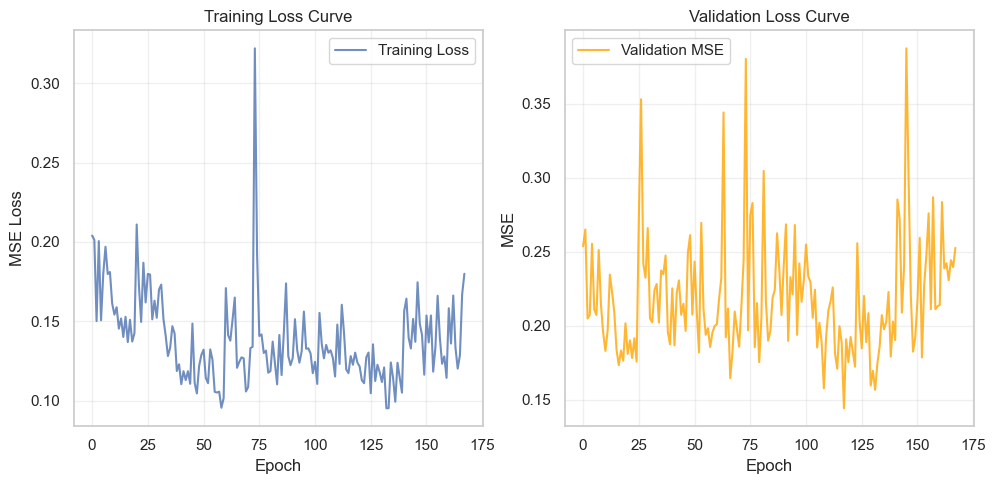

In [17]:
# Plot learning curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)

if val_losses:
    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation MSE', color='orange', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Validation Loss Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'rrl_housing_learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()

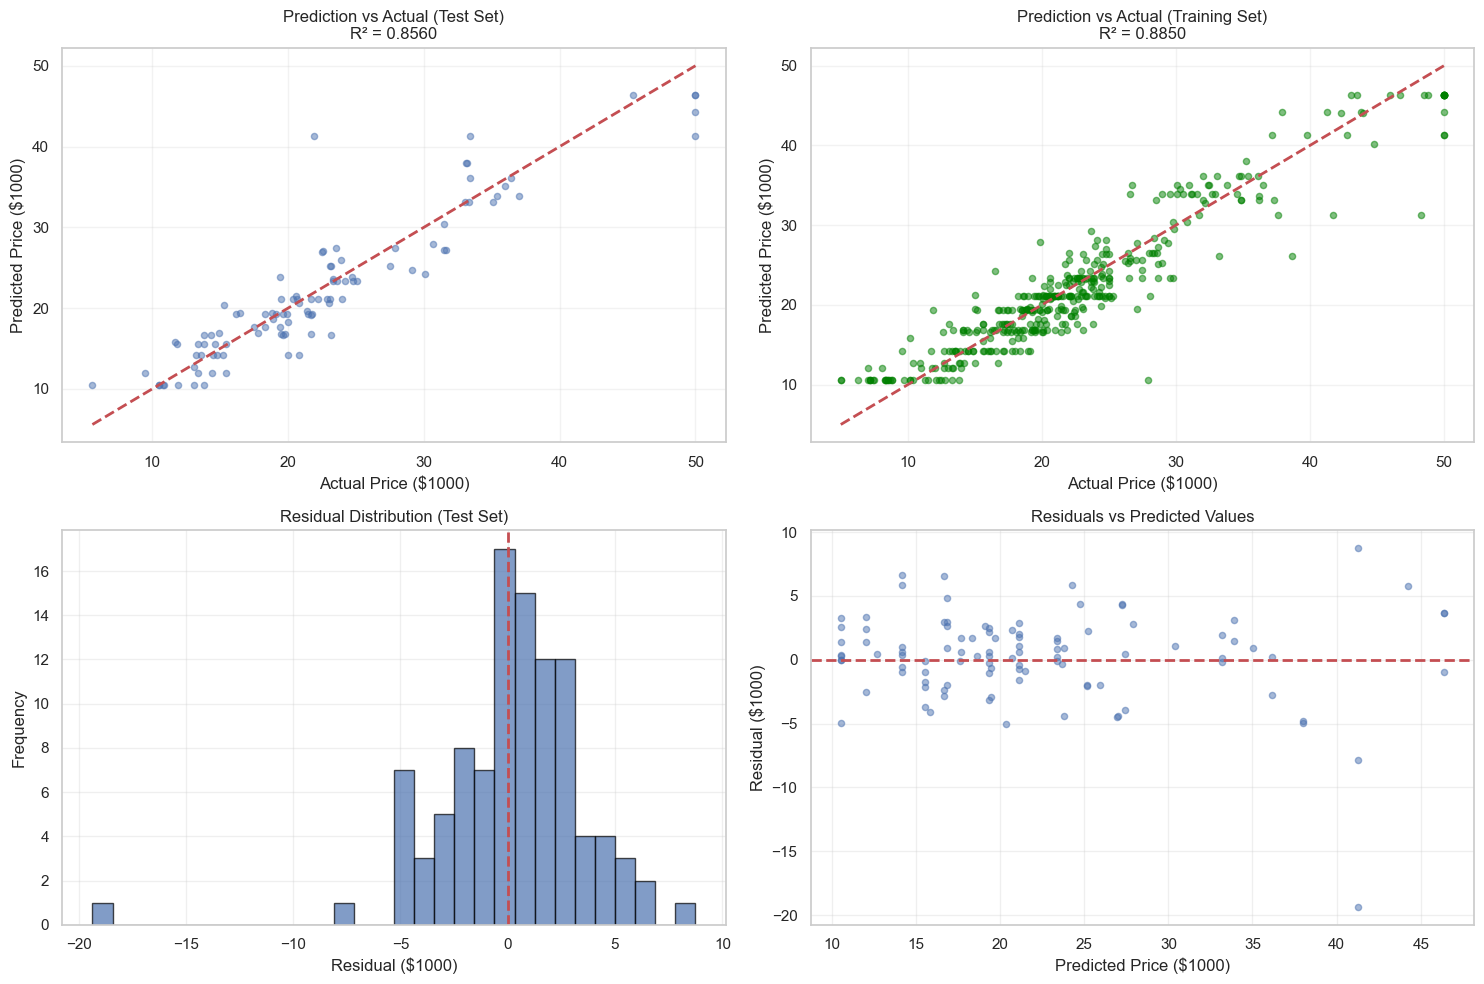

In [18]:
plt.figure(figsize=(15, 10))

# 1. Prediction vs Actual Values (Test Set)
plt.subplot(2, 2, 1)
plt.scatter(Y_test.values, y_pred_test, alpha=0.5, s=20)
min_val = min(Y_test.min(), y_pred_test.min())
max_val = max(Y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Actual Price ($1000)')
plt.ylabel('Predicted Price ($1000)')
plt.title(f'Prediction vs Actual (Test Set)\nR² = {test_metrics["R2"]:.4f}')
plt.grid(True, alpha=0.25)

# 2. Prediction vs Actual Values (Training Set)
plt.subplot(2, 2, 2)
plt.scatter(Y_train.values, y_pred_train, alpha=0.5, s=20, color='green')
min_val = min(Y_train.min(), y_pred_train.min())
max_val = max(Y_train.max(), y_pred_train.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
plt.xlabel('Actual Price ($1000)')
plt.ylabel('Predicted Price ($1000)')
plt.title(f'Prediction vs Actual (Training Set)\nR² = {train_metrics["R2"]:.4f}')
plt.grid(True, alpha=0.25)

# 3. Residue distribution (Test Set)
plt.subplot(2, 2, 3)
residuals = Y_test.values - y_pred_test
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residual ($1000)')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Test Set)')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(y_pred_test, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Price ($1000)')
plt.ylabel('Residual ($1000)')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'rrl_housing_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Extract and Print Rules

One of the key advantages of RRL is its interpretability through learned rules.

In [19]:
# Get feature names for rule printing
# The encoder produces feature names in order: categorical (one-hot) then numeric
rrl_feature_names = list(feature_names)

# Get mean and std for continuous features (for denormalizing rules)
num_transformer = preprocessor.named_transformers_['num']
mean_values = pd.Series(num_transformer.mean_, index=numeric_cols)
std_values = pd.Series(num_transformer.scale_, index=numeric_cols)

print(f"Feature names for rules: {rrl_feature_names}")

Feature names for rules: ['cat__CHAS_0.0', 'cat__CHAS_0.3333333333333333', 'cat__CHAS_1.0', 'num__ZN', 'num__INDUS', 'num__NOX', 'num__RM', 'num__AGE', 'num__DIS', 'num__PTRATIO', 'num__B', 'num__LSTAT', 'num__CRT_COMBO']


In [20]:
# Print rules to file and console
rrl_rules_path = MODELS_DIR / 'rrl_housing_rules.txt'

print("\n" + "=" * 80)
print("LEARNED RULES FOR BOSTON HOUSING PRICE PREDICTION")
print("=" * 80)

with open(rrl_rules_path, 'w') as f:
    f.write("RRL Rules for Boston Housing Price Prediction\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Model Performance:\n")
    f.write(f"  Test MSE:  {test_metrics['MSE']:.4f}\n")
    f.write(f"  Test RMSE: {test_metrics['RMSE']:.4f}\n")
    f.write(f"  Test MAE:  {test_metrics['MAE']:.4f}\n")
    f.write(f"  Test R²:   {test_metrics['R2']:.4f}\n\n")
    f.write("Learned Rules:\n")
    f.write("-" * 80 + "\n")
    
    try:
        rules = rrl_model.rule_print(
            rrl_feature_names, 
            train_loader, 
            file=f,
            mean=mean_values,
            std=std_values
        )
        print(f"\nRules saved to: {rrl_rules_path}")
    except Exception as e:
        print(f"Could not extract rules: {e}")
        f.write(f"Could not extract rules: {e}\n")


LEARNED RULES FOR BOSTON HOUSING PRICE PREDICTION
Could not extract rules: 'num__ZN'


## 10. Model Comparison Summary

In [21]:
# Summary
print("\n" + "=" * 60)
print("RRL REGRESSION MODEL SUMMARY")
print("=" * 60)
print(f"\nDataset: Boston Housing")
print(f"Features: {total_features} ({discrete_flen} discrete, {continuous_flen} continuous)")
print(f"Training samples: {len(Y_train)}")
print(f"Test samples: {len(Y_test)}")
print(f"\nBest Hyperparameters:")
print(f"  Learning rate: {best_params['lr']}")
print(f"  Temperature: {best_params['temperature']}")
print(f"  Structure: {best_params['structure']}")
print(f"\nTest Set Performance:")
print(f"  MSE:  {test_metrics['MSE']:.4f}")
print(f"  RMSE: {test_metrics['RMSE']:.4f}")
print(f"  MAE:  {test_metrics['MAE']:.4f}")
print(f"  R²:   {test_metrics['R2']:.4f}")
print(f"\nModel saved to: {rrl_model_path}")
print("=" * 60)


RRL REGRESSION MODEL SUMMARY

Dataset: Boston Housing
Features: 13 (3 discrete, 10 continuous)
Training samples: 404
Test samples: 102

Best Hyperparameters:
  Learning rate: 0.01
  Temperature: 0.2
  Structure: [16, 16, 8]

Test Set Performance:
  MSE:  12.1695
  RMSE: 3.4885
  MAE:  2.4136
  R²:   0.8560

Model saved to: /Users/zihanghuang/data-mining/outputs/models/rrl_housing_model.pth


In [22]:
# Save predictions
predictions_df = pd.DataFrame({
    'actual': Y_test.values,
    'predicted': y_pred_test,
    'residual': Y_test.values - y_pred_test
})

predictions_path = PREDICTIONS_DIR / 'rrl_housing_predictions.csv'
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to: {predictions_path}")

Predictions saved to: /Users/zihanghuang/data-mining/outputs/predictions/rrl_housing_predictions.csv
